In [1]:
import numpy as np
from numpy import sqrt, sign, abs, random
from scipy.integrate import solve_ivp, RK45
import matplotlib.pyplot as plt
from dynamicSystem import simulateNonlinearSSM
from threeTank import ThreeTank
import GPy

import sys
sys.path.insert(0, '..')

# imports
from pathlib import Path
import sys  

# Get my_package directory path from Notebook
parent_dir = str(Path().resolve().parents[1])

# Add to sys.path
sys.path.insert(0, parent_dir)

In [2]:
param = {
    'u': 1.2371e-4,
    'c13': 2.5046e-5,
    'c32': 2.5046e-5,
    'c2R': 1.9988e-5,
    'g': 9.81 ,
    'A': 0.0154,
    'sigmaX': 1e-6,
    'sigmaY': 5e-4,
}

In [3]:
x0 = [0,0,0]

t0 =0
tFinal = 100
dt = 1
ts = np.arange(t0, tFinal, dt)


Text(0.5, 0, 't')

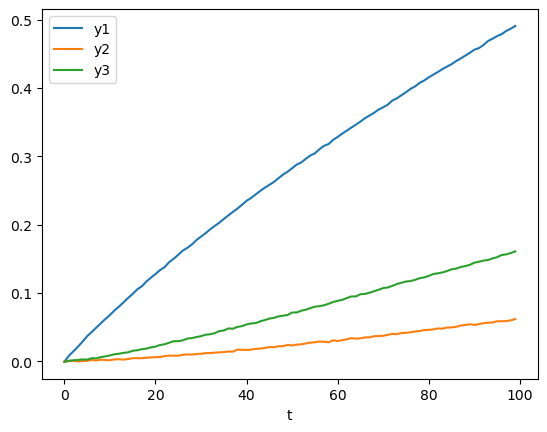

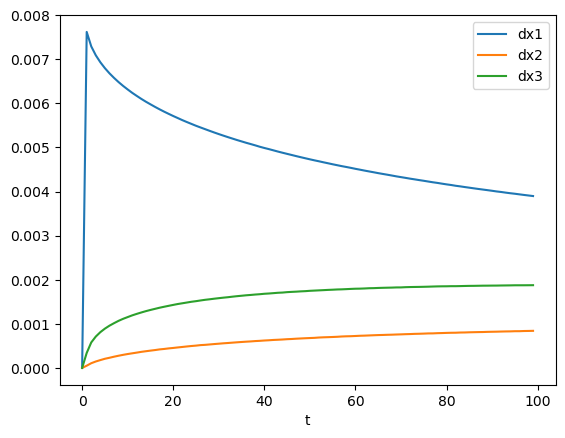

In [4]:
x, y, dx, ts = simulateNonlinearSSM(ThreeTank(param), x0, 1, 100)

plt.figure()

plt.plot(ts, y[0,:], label='y1')
plt.plot(ts, y[1,:], label='y2')
plt.plot(ts, y[2,:], label='y3')
plt.legend()
plt.xlabel('t')

plt.figure()

plt.plot(ts, dx[0,:], label='dx1')
plt.plot(ts, dx[1,:], label='dx2')
plt.plot(ts, dx[2,:], label='dx3')
plt.legend()
plt.xlabel('t')


In [5]:
sigma = param['sigmaY']

se1 = GPy.kern.RBF(input_dim=3, lengthscale=1, variance=1)
se2 = GPy.kern.RBF(input_dim=3, lengthscale=1, variance=1)
se3 = GPy.kern.RBF(input_dim=3, lengthscale=1, variance=1)

# Then
gauss1 = GPy.likelihoods.Gaussian(variance=sigma ** 2)
gauss2 = GPy.likelihoods.Gaussian(variance=sigma ** 2)
gauss3 = GPy.likelihoods.Gaussian(variance=sigma ** 2)

#Xconcat = [y[0,:],y[1,:],y[2,:]]
#xIn = np.transpose(np.expand_dims(y[0,:], axis=0))
#Xconcat = [np.transpose(np.expand_dims(y[0,:], axis=0)), np.transpose(np.expand_dims(y[1,:], axis=0)), np.transpose(np.expand_dims(y[2,:], axis=0))]
Xconcat = [np.transpose(y), np.transpose(y),np.transpose(y) ]
YConcat = [np.transpose(np.expand_dims(dx[0,:], axis=0)),np.transpose(np.expand_dims(dx[1,:], axis=0)), np.transpose(np.expand_dims(dx[2,:], axis=0))]

m = GPy.models.MultioutputGP(
    X_list=Xconcat,
    Y_list=YConcat,
    kernel_list=[se1, se2, se3],
    likelihood_list=[gauss1, gauss2, gauss3],
)

m.optimize(messages=0, ipython_notebook=True)

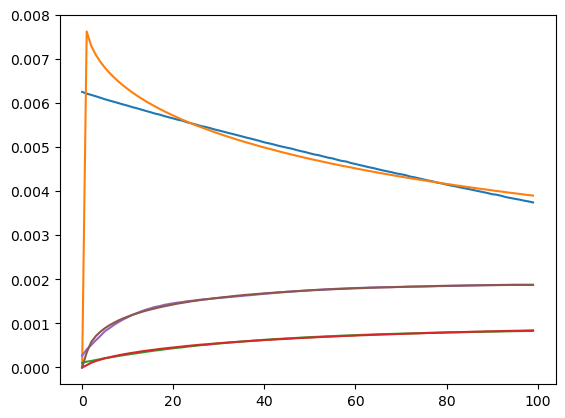

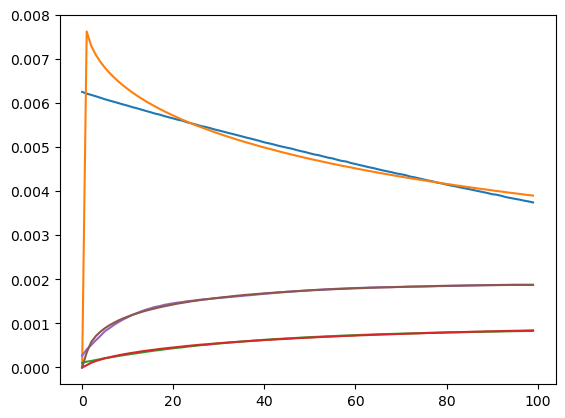

In [6]:
mu1, var1 = m.predict_noiseless(Xnew=[np.transpose(y), np.empty((0, 3)), np.empty((0, 3))])
mu2, var2 = m.predict_noiseless(Xnew=[np.empty((0, 3)), np.transpose(y), np.empty((0, 3))])
mu3, var3 = m.predict_noiseless(Xnew=[np.empty((0, 3)), np.empty((0, 3)), np.transpose(y)])


mu, var = m.predict_noiseless(Xnew=[np.transpose(y), np.transpose(y), np.transpose(y)])

plt.figure()
plt.plot(ts, mu1, label='dx1')
plt.plot(ts, dx[0,:], label='dx1')
plt.plot(ts, mu2, label='dx2')
plt.plot(ts, dx[1,:], label='dx2')
plt.plot(ts, mu3, label='dx3')
plt.plot(ts, dx[2,:], label='dx3')

plt.figure()
plt.plot(ts, mu[0:100], label='dx1')
plt.plot(ts, dx[0,:], label='dx1')
plt.plot(ts, mu[100:200], label='dx2')
plt.plot(ts, dx[1,:], label='dx2')
plt.plot(ts, mu[200:300], label='dx3')
plt.plot(ts, dx[2,:], label='dx3')